In [2]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Markdown
import pandas as pd
import altair as alt
import re
from utils import seconds_to_ms, ms_to_seconds
from results_parser import get_benchmark_results
from benchmarks.overhead_latency import echo

InteractiveShell.ast_node_interactivity = "all"

In [3]:
benchmark_results = get_benchmark_results()


## ipyparallel benchmark results ##

### time_n_tasks ###
The first benchmark comes from benchmarking the runtime of sending
n tasks to m engines. Where the each task is just the echo function. 

In [4]:
??echo

Signature: echo(delay=0)
Docstring: <no docstring>
Source:   
def echo(delay=0):
    def inner_echo(x):
        import time

        if delay:
            time.sleep(delay)
        return x

    return inner_echo
File:      ~/ipyparallel_master_project/benchmarks/overhead_latency.py
Type:      function


In [5]:
def get_dict(): 
    return { 'Duration in ms': [], 'Number of tasks': [], 'Number of engines': [] }

In [6]:
datasource = {'NoDelay': {}}
for machine_name, benchmark_run in benchmark_results.items():
    number_of_cores = int(re.findall('\d+', machine_name)[0])
    for benchmark_name, results in benchmark_run.results_dict.items():
        if not 'time_n_tasks' in benchmark_name or 'NoDelay' in benchmark_name:
            continue
        number_of_engines = re.findall('\d+', benchmark_name)[0]
        for duration, tasks_num, delay in\
            [(result.duration_in_ms, result.number_of_tasks, seconds_to_ms(result.delay)) for result in results]:
            if not delay in datasource:
                datasource[delay] = {number_of_cores: get_dict()}
            if not number_of_cores in datasource[delay]:
                datasource[delay][number_of_cores] = get_dict()
                
            datasource[delay][number_of_cores]['Duration in ms'].append(duration)
            datasource[delay][number_of_cores]['Number of tasks'].append(tasks_num)
            datasource[delay][number_of_cores]['Number of engines'].append(number_of_engines)
    datasource['NoDelay'][number_of_cores] = {'Duration in ms': [], 'Number of tasks': []}
    for result in benchmark_run.results_dict['overhead_latency.Engines100NoDelay.time_n_tasks']:
        if result.failed:
            continue
        datasource['NoDelay'][number_of_cores]['Duration in ms'].append(result.duration_in_ms)
        datasource['NoDelay'][number_of_cores][ 'Number of tasks'].append(result.number_of_tasks)

,Duration in ms,Number of tasks
0,2719.82,1000
1,27470.17,10000


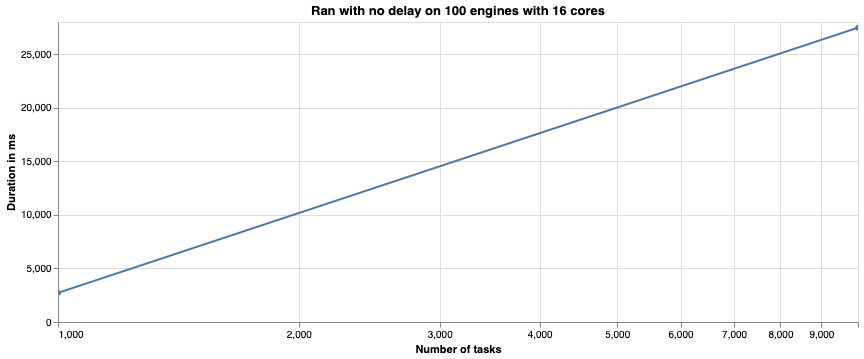

,Duration in ms,Number of tasks
0,262.76,100
1,2543.71,1000
2,26383.06,10000


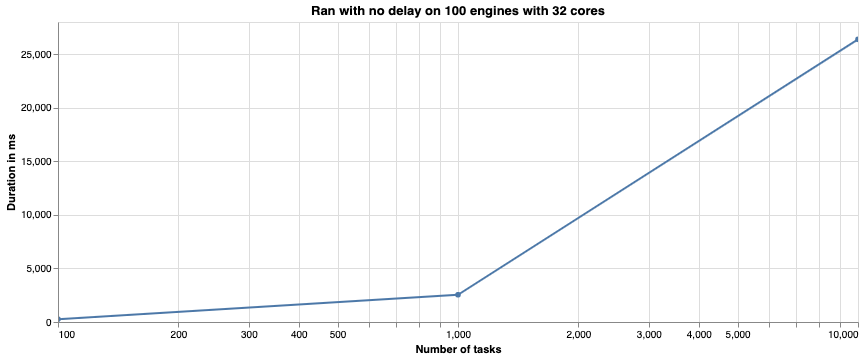

,Duration in ms,Number of tasks
0,7.26,1
1,28.97,10
2,247.37,100
3,2474.36,1000
4,24884.53,10000


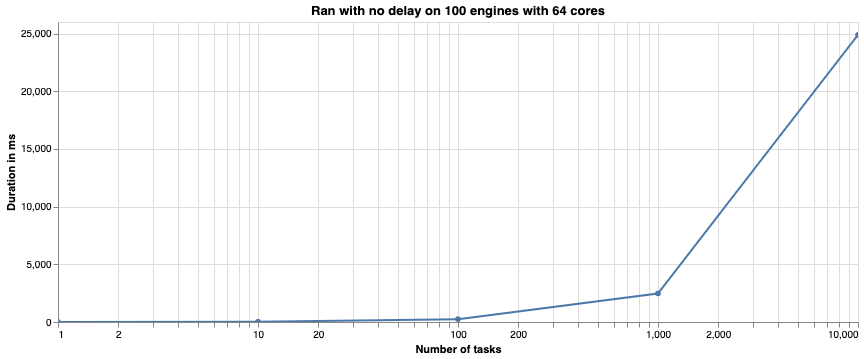

### With a delay of 0.0s. :

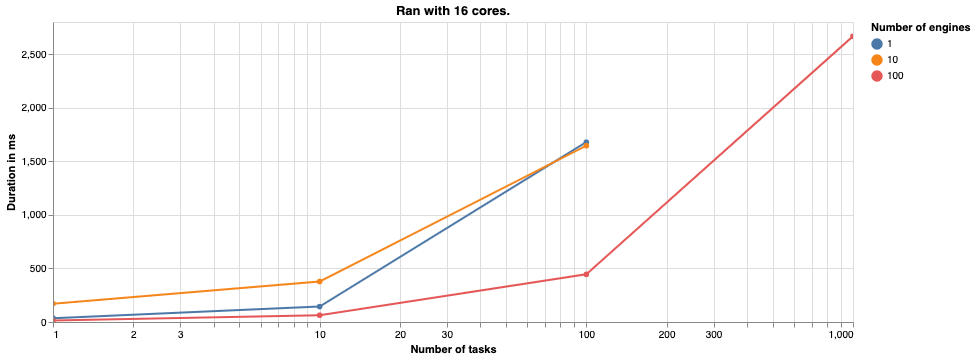

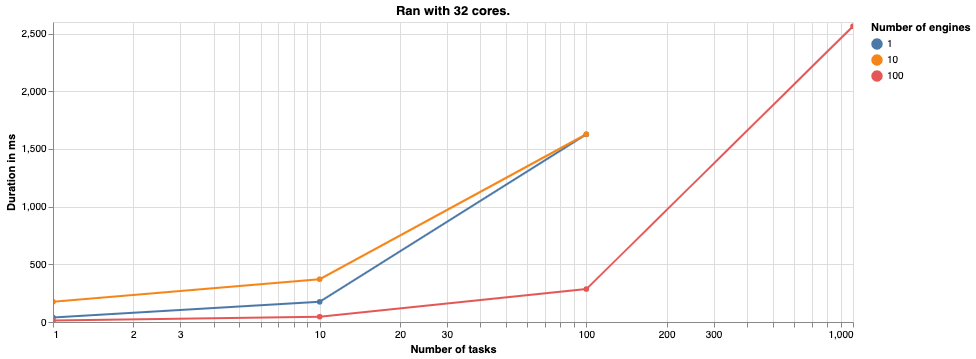

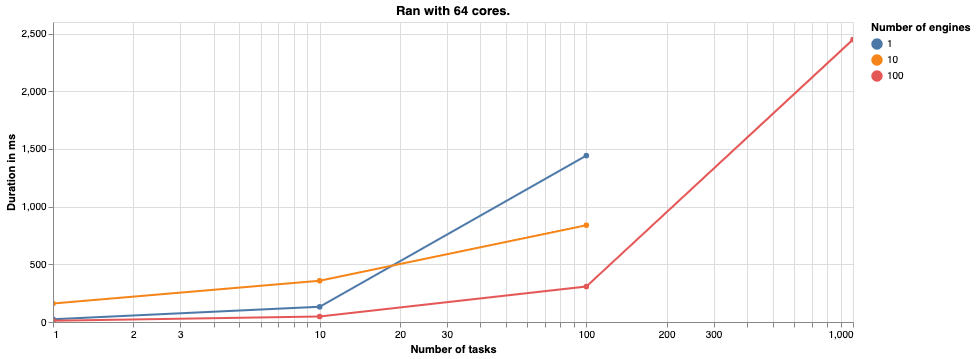

### With a delay of 0.1s. :

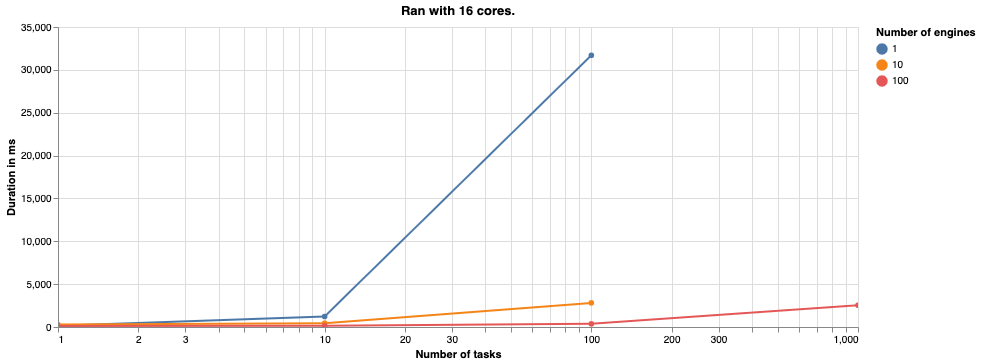

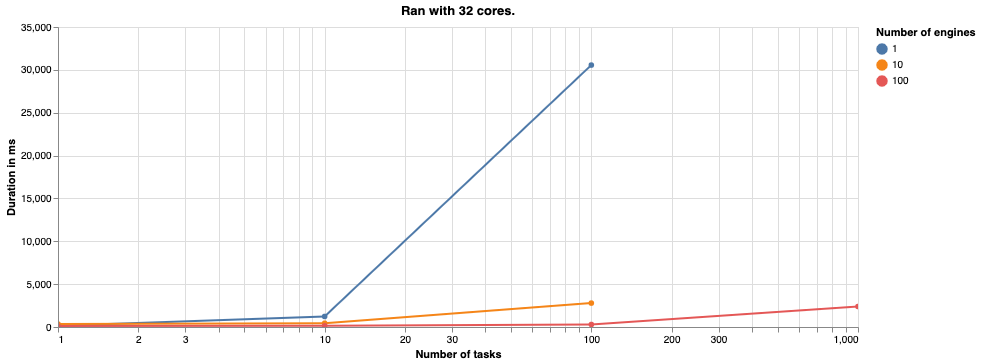

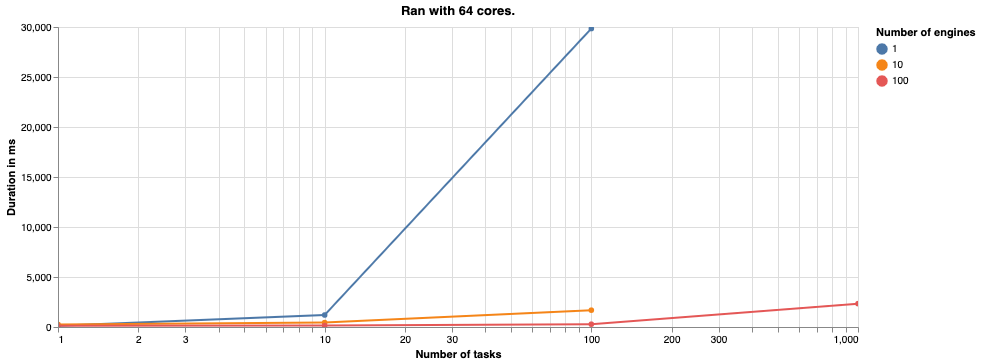

### With a delay of 1.0s. :

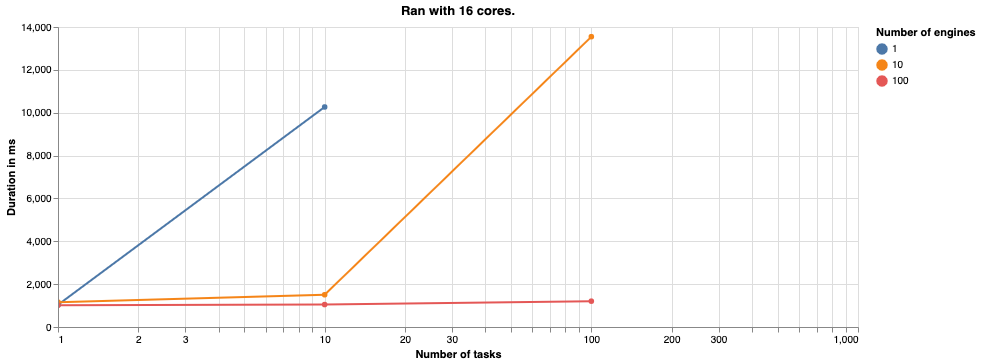

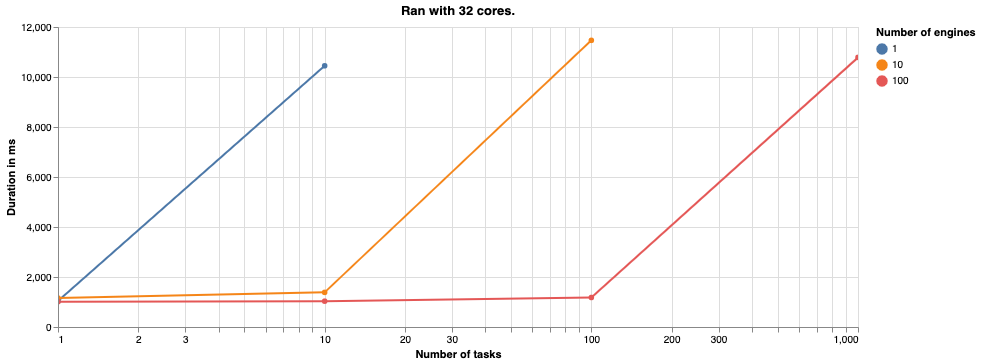

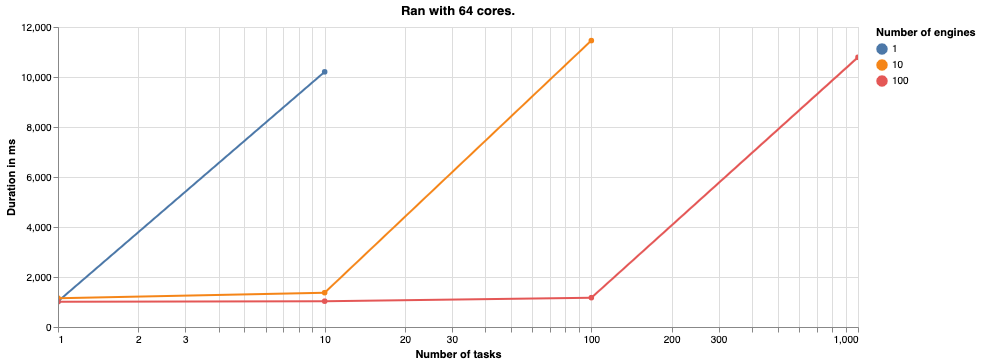

In [8]:
for delay, result_for_delay in datasource.items():
    if 'NoDelay' != delay:
        display(Markdown(f'### With a delay of {ms_to_seconds(delay)}s. :'))
        for core_num, results in result_for_delay.items():            
            data = pd.DataFrame(results)
            alt.Chart(data).mark_line(point=True).encode(
                alt.X('Number of tasks',  scale=alt.Scale(type='log')),
                y='Duration in ms',
                color='Number of engines:N',
                tooltip='Duration in ms'            
            ).properties(title=f'Ran with {core_num} cores.',  width=800
).interactive().display(renderer='svg')
    else:
        for core_num, results in result_for_delay.items():
            data = pd.DataFrame(results)
            data            
            alt.Chart(data).mark_line(point=True).encode(
                alt.X('Number of tasks',  scale=alt.Scale(type='log')),
                y='Duration in ms',
                tooltip='Duration in ms',                         
            ).properties(title=f'Ran with no delay on 100 engines with {core_num} cores', width=800).interactive().display(renderer='svg')